In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import statsmodels.formula.api as smf
%pylab inline
print sys.version

Populating the interactive namespace from numpy and matplotlib
2.7.11 (default, Dec  5 2015, 14:44:47) 
[GCC 4.2.1 Compatible Apple LLVM 7.0.0 (clang-700.1.76)]


`%matplotlib` prevents importing * from pylab and numpy


In [86]:
# read in data
data = pd.read_csv('datasets/GDP.csv')
data.DATE = pd.to_datetime(data.DATE)
data.reset_index(inplace = True)
data.rename(columns = {'DATE':'date','GDP':'gdp', 'index':'quarter'}, inplace = True)
#data.set_index('DATE', inplace = True)
data.head()

,quarter,date,gdp
0,0,1947-01-01,1934.471
1,1,1947-04-01,1932.281
2,2,1947-07-01,1930.315
3,3,1947-10-01,1960.705
4,4,1948-01-01,1989.535


The GDP over time does *not* appear to grow linearly over time. Visual inspection of the data shows periods of both growth and decline. Even after smoothing those out, the growth still appears to be nonlinear.

In [87]:
data.head()

,quarter,date,gdp
0,0,1947-01-01,1934.471
1,1,1947-04-01,1932.281
2,2,1947-07-01,1930.315
3,3,1947-10-01,1960.705
4,4,1948-01-01,1989.535


In [88]:
data['log_gdp'] = log(data.gdp)

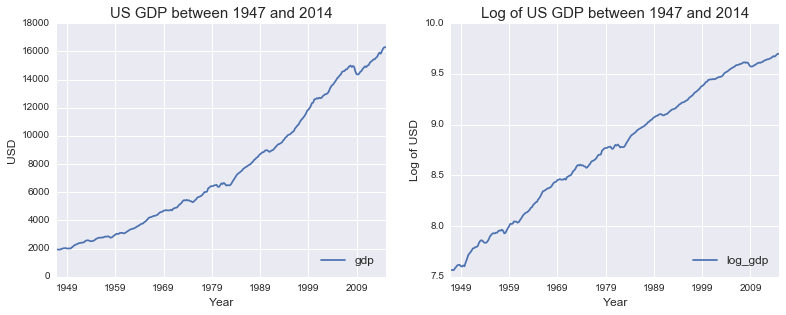

In [122]:
fig, ax = plt.subplots(figsize = (20,10))

plt.subplot(2,3,1)
plt.plot(data.date, data.gdp)
plt.xlabel('Year', fontsize = 12)
plt.ylabel('USD', fontsize = 12)
plt.title('US GDP between 1947 and 2014', fontsize = 15)
plt.legend(loc = 4, fontsize = 12)

plt.subplot(2,3,2)
plt.plot(data.date, data.log_gdp)
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Log of USD', fontsize = 12)
plt.title('Log of US GDP between 1947 and 2014', fontsize = 15)
plt.legend(loc = 4, fontsize = 12)

# plt.subplot(2,3,3)
# plt.plot(data.date, data.log_gdp)
# plt.xlabel('Year', fontsize = 14)
# plt.ylabel('Log of USD', fontsize = 14)
# plt.title('Log of US GDP between 1947 and 2014', fontsize = 20)
# plt.legend(loc = 4)

The GDP over time does not appear to grow linearly over time. Visual inspection of the data shows periods of both growth and decline. Even after smoothing those out, the growth still appears to be nonlinear.

Graphing in log space displays values across an order of magnitude, rather than their true values. Since GDP does not grow in orders of magnitude between periods, the curve becomes flatter and appears more linear.

In [91]:
mod = smf.ols(formula = 'log_gdp ~ quarter', data = data).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:                log_gdp   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 3.019e+04
Date:                Mon, 15 Feb 2016   Prob (F-statistic):          6.51e-280
Time:                        19:17:37   Log-Likelihood:                 379.74
No. Observations:                 273   AIC:                            -755.5
Df Residuals:                     271   BIC:                            -748.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      7.6576      0.007   1049.740      0.0

In [92]:
print 'Our model predicts that the GDP of the US in Q1 2015 will be',mod.params[0] * 274

Our model predicts that the GDP of the US in Q1 2015 will be 2098.18800406


In [93]:
conf = mod.conf_int()
conf.rename(columns = {0:'conf_int_lower',1:'conf_int_higher'}, inplace = True)
print conf

           conf_int_lower  conf_int_higher
Intercept        7.643259         7.671982
quarter          0.007972         0.008155


In [94]:
int_forecast = mod.params[0] + (mod.params[1] * 274)
ci_high = conf['conf_int_higher'][0] + (conf['conf_int_higher'][1] * 274)
ci_lower = conf['conf_int_lower'][0] + (conf['conf_int_lower'][1] * 274)

print 'Prediction:',int_forecast
print 'CI Upper Bound:', ci_high
print 'CI Lower Bound:', ci_lower

Prediction: 9.86695858008
CI Upper Bound: 9.90635522089
CI Lower Bound: 9.82756193927


In [95]:
# create a new column in the dataframe that has the values we will use for the best fit line
my_list = []

for i in (data.index)+1:
    my_list.append((mod.params[0])+mod.params[1]*i)

data['linmodel'] = my_list
data.head(1)

,quarter,date,gdp,log_gdp,linmodel
0,0,1947-01-01,1934.471,7.567589,7.665684


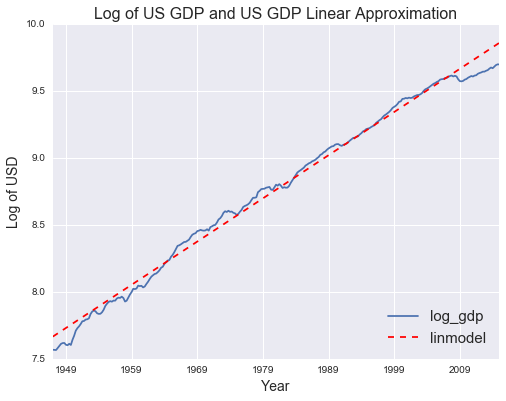

In [96]:
fig, ax = plt.subplots(figsize = (8,6))
plt.plot(data.date, data.log_gdp)
plt.plot(data.date, data.linmodel, ls = '--', color = 'red')
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Log of USD', fontsize = 14)
plt.title('Log of US GDP and US GDP Linear Approximation', fontsize = 16)
plt.legend(loc = 4, fontsize = 15)


In [97]:
# add new column that calculates the residuals
data['residuals'] = data['log_gdp'] - data['linmodel']
data.head(1)

,quarter,date,gdp,log_gdp,linmodel,residuals
0,0,1947-01-01,1934.471,7.567589,7.665684,-0.098095


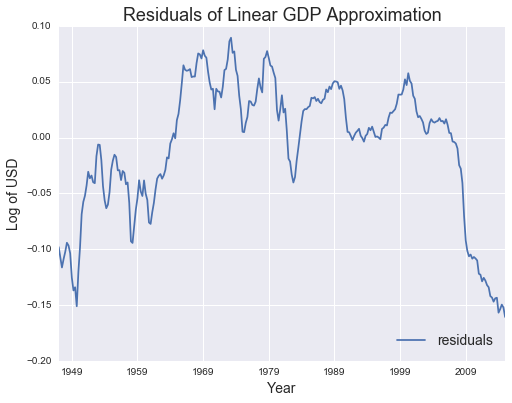

In [98]:
# plt.plot(data.date, data.log_gdp)
# plt.plot(data.date, data.linmodel)
ax, fig = plt.subplots(figsize = (8,6))
plt.plot(data.date, data.residuals)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Log of USD', fontsize = 14)
plt.title('Residuals of Linear GDP Approximation', fontsize = 18)
plt.legend(loc = 4, fontsize= 14)

The erratic residuals over time undermine our confidence in the model's predictive abilities, especially over the short term due to the high variance between the residuals between quarters. While the model appears mostly linear over the observed period, one cannot 

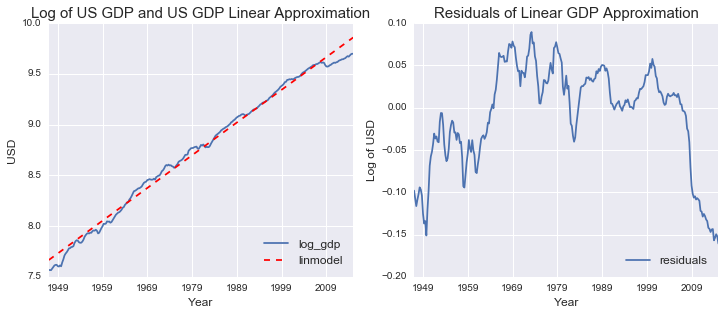

In [119]:
# graph residuals and best fit line as subplots

fig, ax = plt.subplots(figsize = (12,10))

plt.subplot(2,2,1)
plt.plot(data.date, data.log_gdp)
plt.plot(data.date, data.linmodel, ls = '--', color = 'red')
plt.xlabel('Year', fontsize = 12)
plt.ylabel('USD', fontsize = 12)
plt.title('Log of US GDP and US GDP Linear Approximation', fontsize = 15)
plt.legend(loc = 4, fontsize = 12)

plt.subplot(2,2,2)
plt.plot(data.date, data.residuals)
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Log of USD', fontsize = 12)
plt.title('Residuals of Linear GDP Approximation', fontsize = 15)
plt.legend(loc = 4, fontsize = 12)

In [100]:
#EURO PROBLEM

In [101]:
# read in euro dataset and convert to datetime
df = pd.read_csv('datasets/euro.csv')
df.rename(columns = {'DATE':'date','EURO':'euro'}, inplace = True)
df.reset_index(inplace = True)
df.date = pd.to_datetime(df.date)
df.head()

,index,date,euro
0,0,1999-01-04,1.1812
1,1,1999-01-05,1.1760
2,2,1999-01-06,1.1636
3,3,1999-01-07,1.1672
4,4,1999-01-08,1.1554


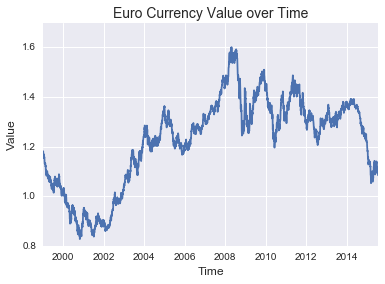

In [102]:
plt.plot(df.date, df.euro)
plt.title('Euro Currency Value over Time', fontsize = 14)
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Value', fontsize = 12)

Upon visual inspection, it is clear that a linear model is inappropriate for predicting the Euro's value. It is inappropriate because of the high variabi

In [103]:
mod700 = smf.ols(formula = 'euro ~ index', data = df[df.index <= 700]).fit()
print mod700.summary()

                            OLS Regression Results                            
Dep. Variable:                   euro   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     2924.
Date:                Mon, 15 Feb 2016   Prob (F-statistic):          6.21e-252
Time:                        19:17:39   Log-Likelihood:                 1307.6
No. Observations:                 701   AIC:                            -2611.
Df Residuals:                     699   BIC:                            -2602.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.0992      0.003    388.220      0.0

In [104]:
mod_rest = smf.ols(formula = 'euro ~ index', data = df[df.index > 700]).fit()
print mod_rest.summary()

                            OLS Regression Results                            
Dep. Variable:                   euro   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     1141.
Date:                Mon, 15 Feb 2016   Prob (F-statistic):          2.40e-216
Time:                        19:17:39   Log-Likelihood:                 2192.3
No. Observations:                3458   AIC:                            -4381.
Df Residuals:                    3456   BIC:                            -4368.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.0941      0.006    190.441      0.0

In [123]:
# create a variable that is the index of the target date, which is july 15th, 2015 in this case
# this will be used as the x variable in our forecast model
x = df[df['date'] == '2015-07-17'].index[0]
x

4158

In [124]:
# create df that includes params from mod700 model
int_fc_700 = mod700.params
print int_fc_700

print ''

# then create df that contains params from the remaining data
int_fc_rest = mod_rest.params
print int_fc_rest

Intercept    1.099165
index       -0.000379
dtype: float64

Intercept    1.094116
index        0.000074
dtype: float64


In [125]:
# create dataframes that include the confidence intervals from each model
conf700 = mod700.conf_int()
conf700.rename(columns = {0:'conf_int_lower', 1:'conf_int_higher'}, inplace = True)
print conf700

print ''

conf_rest = mod_rest.conf_int()
conf_rest.rename(columns = {0:'conf_int_lower', 1:'conf_int_higher'}, inplace = True)
print conf_rest

           conf_int_lower  conf_int_higher
Intercept        1.093606         1.104724
index           -0.000392        -0.000365

           conf_int_lower  conf_int_higher
Intercept        1.082852         1.105381
index            0.000070         0.000078


In [126]:
# first make the prediction using the first 700 values
int_forecast = mod700.params[0] + (mod700.params[1] * x)
ci_high = conf700['conf_int_higher'][0] + (conf700['conf_int_higher'][1] * x)
ci_lower = conf700['conf_int_lower'][0] + (conf700['conf_int_lower'][1] * x)

print 'Prediction:',int_forecast
print 'CI Upper Bound:', ci_high
print 'CI Lower Bound:', ci_lower

Prediction: -0.475311811795
CI Upper Bound: -0.412581642051
CI Lower Bound: -0.538041981539


In [127]:
# first make the prediction using the remaining values
int_forecast = mod_rest.params[0] + (mod_rest.params[1] * x)
ci_high = conf_rest['conf_int_higher'][0] + (conf_rest['conf_int_higher'][1] * x)
ci_lower = conf_rest['conf_int_lower'][0] + (conf_rest['conf_int_lower'][1] * x)

print 'Prediction:',int_forecast
print 'CI Upper Bound:', ci_high
print 'CI Lower Bound:', ci_lower

Prediction: 1.40129113861
CI Upper Bound: 1.4303872025
CI Lower Bound: 1.37219507473


In [129]:
# extract the value of the euro on this date. did we come close?
df[df.date == '2015-07-17']['euro']

4158    1.0848
Name: euro, dtype: float64

The confidence intervals for both models failed to predict the actual value of the Euro on July 15th, 2015, which was 1.0965 USD per euro. The first model using the first 700 values returned a negative confidence interval and predicted value, which is nonsensical for a currency. The second model including the remaining data returned a prediction and confidence interval much higher than the actual value seen on that day.

The reason this model failed to even come close to the actual value is because there exists covariance between our coefficient and our epsilon (error term, which includes all non-covariant information). Our model attempts to explain the relationship that is actually explained by features that are contained within the error term.  $R^2$